# импорт библиотек

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

**`тест Дики-Фуллера`**

0 гипотеза: ряд данных не стационарен

альтернативная гипотеза: ряд данных стационарен

Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда

In [ ]:
def adf_test(series,title=''):

    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("Отменяем 0 гипотезу")
        print("Данные стационарны")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("Не отменяем 0 гипотезу")
        print("Данные не стационарны")

# загрузка данных

In [ ]:
milk= pd.read_csv("https://drive.google.com/u/0/uc?id=1AbUl7tP_J47ST7L7kc3wxENxmpBUsumS&export=download", index_col="Month", parse_dates=True).drop(['Unnamed: 0'], axis=1)
air_passenger= pd.read_csv("https://drive.google.com/u/0/uc?id=1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST&export=download", index_col="Month", parse_dates=True)
aus_employment= pd.read_csv("https://drive.google.com/u/0/uc?id=1wMwd2mV_nchXgaz3QTPSBl7Xd-ITsPVQ&export=download", index_col="date", parse_dates=True)

In [ ]:
milk.rename(columns = {'Monthly milk production (pounds per cow)':'production'}, inplace = True)

In [ ]:
milk.head()

,production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [ ]:
air_passenger.rename(columns = {'#Passengers':'Passengers'}, inplace = True)

In [ ]:
air_passenger.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
aus_employment.head()

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3


# Данные о молочной продукции

In [ ]:
print('min - ', milk.min())

print('max - ', milk.max())

min -  production    553
dtype: int64
max -  production    969
dtype: int64


In [ ]:
milk.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

<Axes: xlabel='Month'>

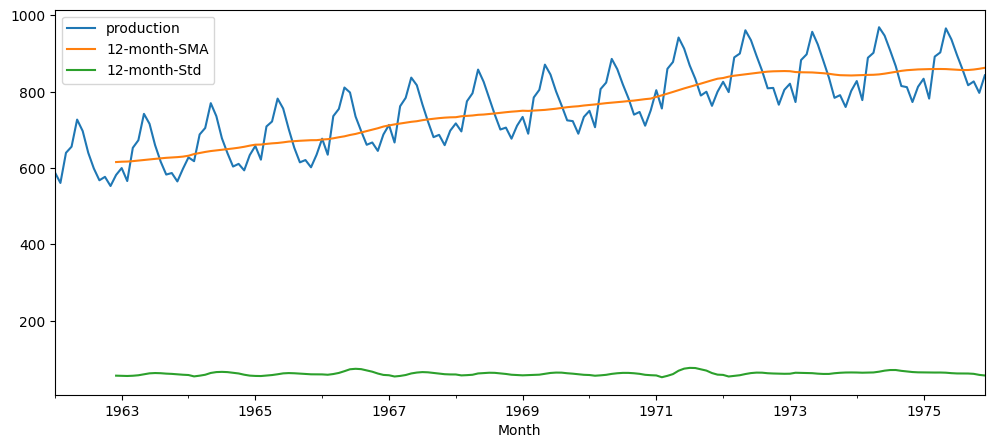

In [ ]:
# дескриптивная аналитики
milk['12-month-SMA'] = milk['production'].rolling(window=12).mean()
milk['12-month-Std'] = milk['production'].rolling(window=12).std()

milk[['production','12-month-SMA','12-month-Std']].plot(figsize=(12,5))

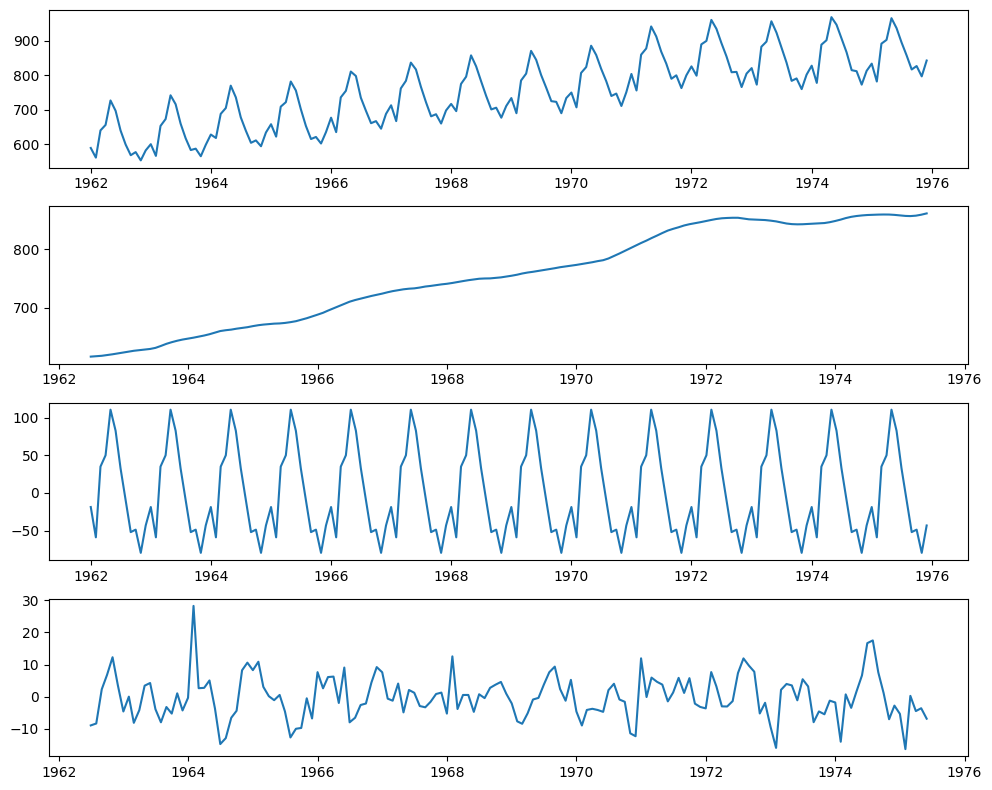

In [ ]:
decomposition = seasonal_decompose(milk["production"], model="add")
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[1].plot(decomposition.trend)
axes[2].plot(decomposition.seasonal)
axes[3].plot(decomposition.resid)

plt.tight_layout()
plt.show()

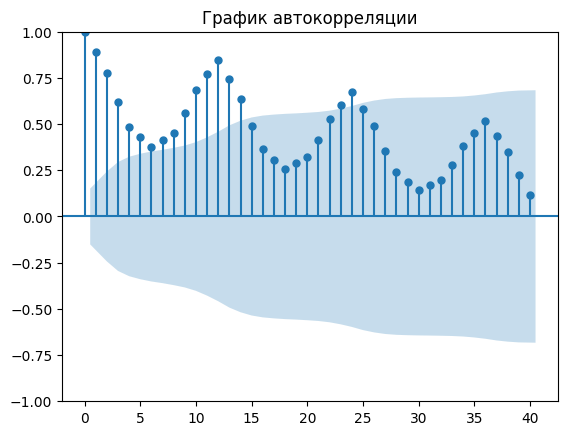

In [ ]:
# ACF
plot_acf(milk["production"],title='График автокорреляции', lags=40)
plt.show()

In [ ]:
# тест на стационарность

In [ ]:
adf_test(milk["production"])

ADF тест                       -1.303812
p-value                         0.627427
# lags used                    13.000000
# наблюдения                  154.000000
критическое значение (1%)      -3.473543
критическое значение (5%)      -2.880498
критическое значение (10%)     -2.576878
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


сконвертируем нестационарный ряд в стационарный


<Axes: xlabel='Month'>

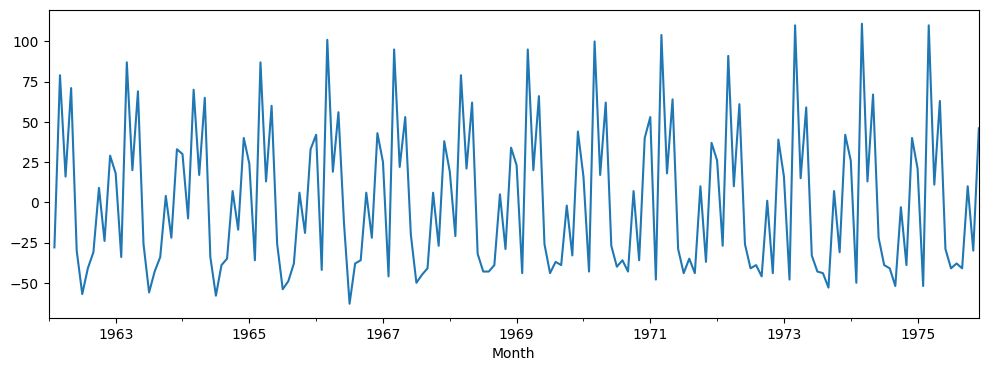

In [ ]:
milk["difference_1"]= diff(milk["production"], k_diff=1)
milk["difference_1"].plot(figsize=(12,4))

In [ ]:
adf_test(milk["difference_1"])

ADF тест                       -3.054996
p-value                         0.030068
# lags used                    14.000000
# наблюдения                  152.000000
критическое значение (1%)      -3.474121
критическое значение (5%)      -2.880750
критическое значение (10%)     -2.577013
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='Month'>

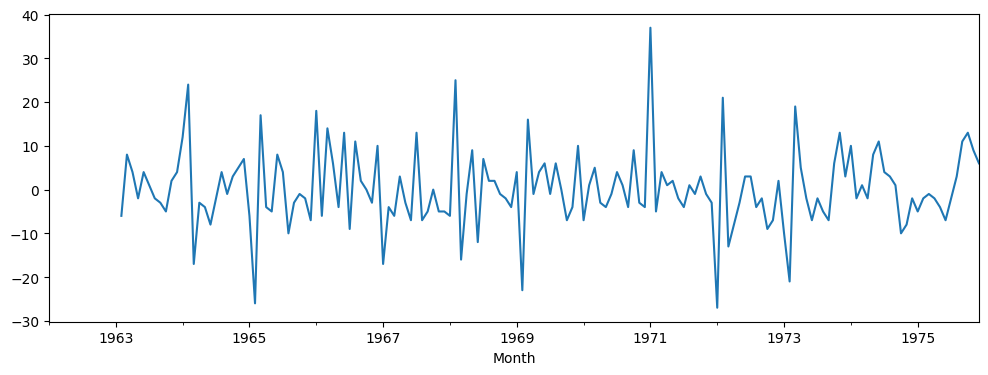

In [ ]:
# стационарность после сезонной разности
milk["difference_seasonal"]= diff(milk["production"], k_diff=1,k_seasonal_diff= 1,seasonal_periods= 12)
milk["difference_seasonal"].plot(figsize=(12,4))

In [ ]:
adf_test(milk["difference_seasonal"])

ADF тест                       -5.038002
p-value                         0.000019
# lags used                    11.000000
# наблюдения                  143.000000
критическое значение (1%)      -3.476927
критическое значение (5%)      -2.881973
критическое значение (10%)     -2.577665
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### ARIMA: обучение модели без сезонной составляющей

In [ ]:
# разделим на тестовый и тренировочный набор данных
train= milk.iloc[:len(milk)-12]
test= milk.iloc[len(milk)-12:]

In [ ]:
print(len(train))
print(len(test))

156
12


In [ ]:
auto_arima_results= auto_arima(train["production"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1624.299, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1626.095, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1626.164, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1622.458, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1627.823, Time=1.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.952 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -810.229
Date:                Wed, 12 Jul 2023   AIC                           1622.458
Time:                        12:43:51   BIC                           1625.502
Sample:                    01-01-1962   HQIC                          1623.695
                         - 12-01-1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2031.8406    275.034      7.388      0.000    1492.784    2570.897
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                13.50
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.64
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

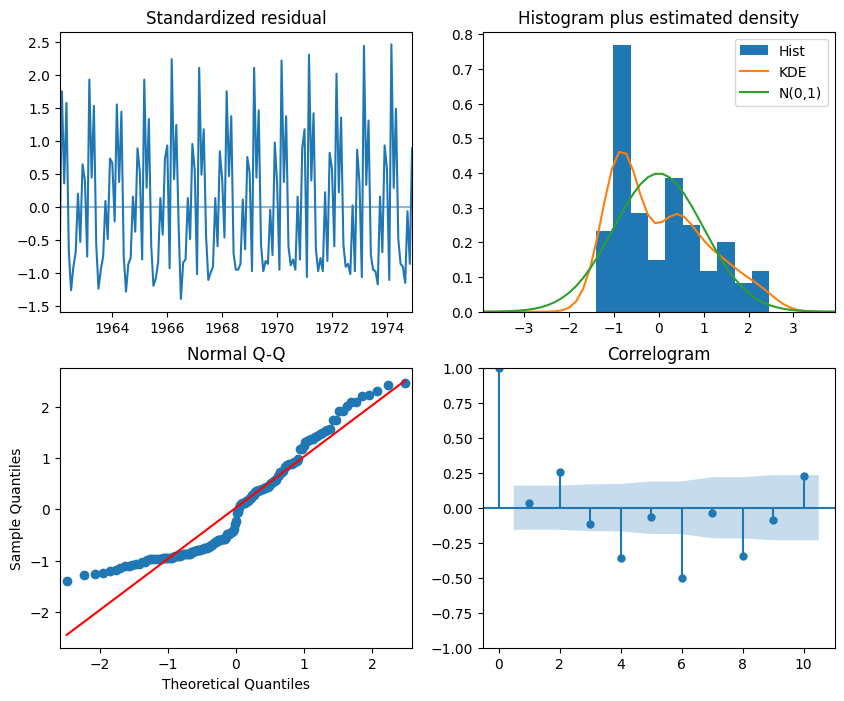

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

#### обучим модель ARIMA используя p,d,q из полученного результата по auto_arima

In [ ]:
arima_model= ARIMA(train["production"], order= (0,1,0))
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
normaltest(arima_model_fit.resid)

NormaltestResult(statistic=196.55399617787913, pvalue=2.0837328189718305e-43)

p-value не менее 0.05 , это означает, что остатки нормально распределены

### прогноз на test наборе данных

In [ ]:
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='Month'>

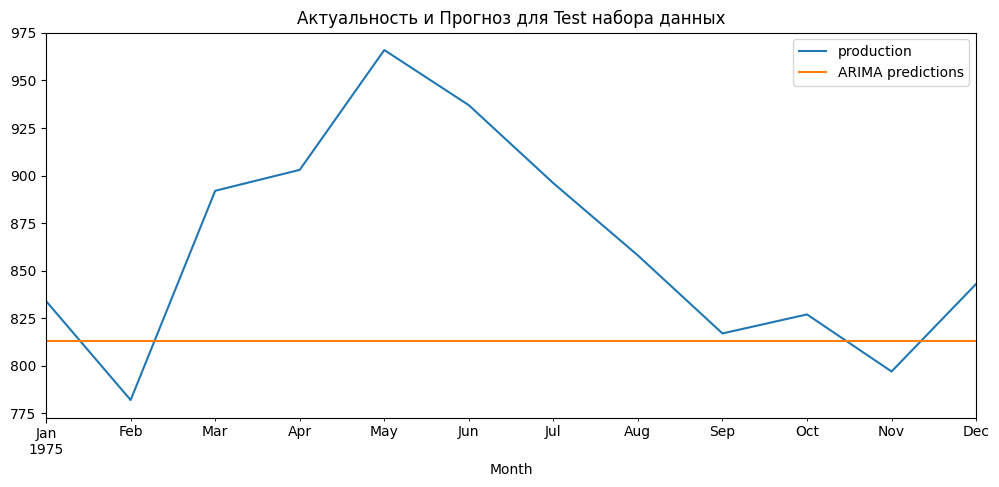

In [ ]:
title= "Актуальность и Прогноз для Test набора данных"
test["production"].plot(figsize=(12,5), title= title, legend=True);
pred.plot(legend=True)

In [ ]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["production"],pred)
rmse_arima= rmse(test["production"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 73.4903621799031 

MSE= 5400.833333333333


## ARIMA: обучение модели с сезонной составляющей

In [ ]:

smodel = auto_arima(train["production"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1203.992, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.095, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1015.855, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1104.312, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1349.320, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1039.187, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1006.896, Time=2.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1001.453, Time=2.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1001.195, Time=0.67 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=999.197, Time=0.42 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1001.194, Time=1.51 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=4.95 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=994.889, Time=0.60 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1035.695, Time=0.17 sec
 ARIMA(2,0,0)(1,1,1)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Wed, 12 Jul 2023   AIC                            994.862
Time:                                    13:10:51   BIC                           1015.650
Sample:                                01-01-1962   HQIC                          1003.309
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3091      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096     -2.430      0.015      -0.422      -0.045
ar.L2          0.8181      0.077     10.611      0.000       0.667       0.969
ar.L3          0.2510      0.096      2.619      0.009       0.063       0.439
ma.L1          0.9588      0.071     13.599      0.000       0.821       1.097
ma.S.L12      -0.6026      0.087     -6.947      0.000      -0.773      -0.433
sigma2        50.4394      5.268      9.575      0.000      40.115      60.764
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                50.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.84
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE= 10.836299800637837 

MSE= 117.42539336930365


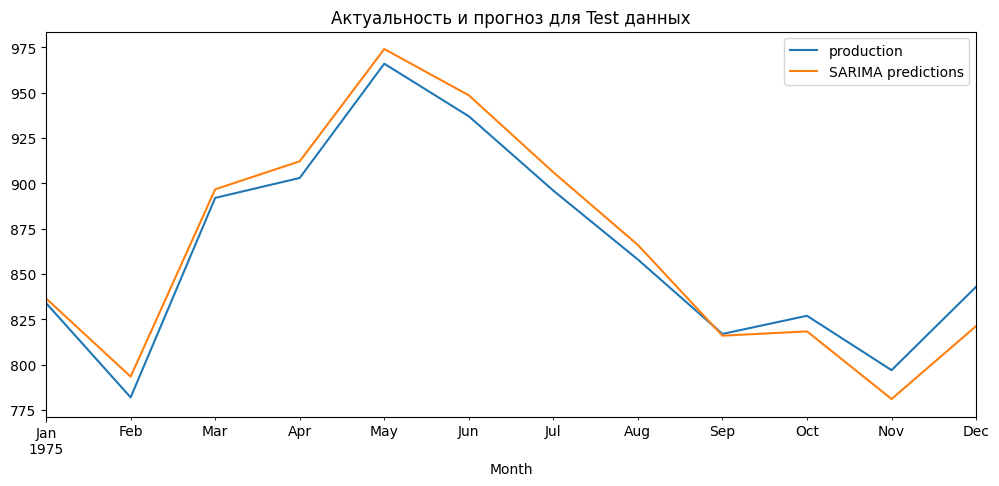

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["production"], order= (3,0,1), seasonal_order= (0,1,1,12))
sarima_model_fit= sarima_model.fit()

# сделаем пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["production"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценим модель
mse= mean_squared_error(test["production"],pred)
rmse_sarima= rmse(test["production"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train['production'],
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # переопределим первичный индекс


# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-42-72beb8e03036>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-42-72beb8e03036>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
# SARIMAX модель
sxmodel = auto_arima(train2["production"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1203.992, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.095, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1015.855, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1104.312, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1349.320, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1039.187, Time=0.40 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1006.896, Time=3.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1001.453, Time=5.80 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1001.195, Time=1.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=999.197, Time=0.69 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1001.194, Time=2.23 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.62 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=994.889, Time=1.33 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1035.695, Time=0.34 sec
 ARIMA(2,0,0)(1,1,1)[12] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Wed, 12 Jul 2023   AIC                            994.862
Time:                                    13:13:22   BIC                           1015.650
Sample:                                01-01-1962   HQIC                          1003.309
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3091      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096     -2.430      0.015      -0.422      -0.045
ar.L2          0.8181      0.077     10.611      0.000       0.667       0.969
ar.L3          0.2510      0.096      2.619      0.009       0.063       0.439
ma.L1          0.9588      0.071     13.599      0.000       0.821       1.097
ma.S.L12      -0.6026      0.087     -6.947      0.000      -0.773      -0.433
sigma2        50.4394      5.268      9.575      0.000      40.115      60.764
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                50.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.84
Prob(H) (two-sided):                  0.34   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Square is 10.836300335997 

Mean Square Error is 117.4254049719287


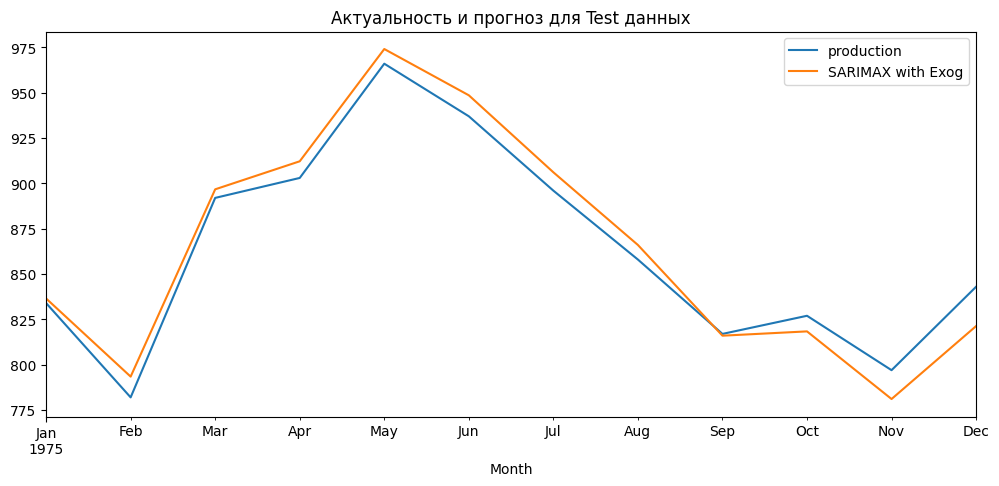

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["production"], order= (3,0,1), seasonal_order= (0,1,1,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

title= "Актуальность и прогноз для Test данных"
test["production"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценка модели
mse= mean_squared_error(test["production"],pred)
rmse_sarimax= rmse(test["production"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

In [ ]:
# перетренируем модель на всем объеме данных для прогноза
model= SARIMAX(milk["production"], order= (3,0,1), seasonal_order= (0,1,1,12))
results= model.fit()

start= len(milk)
end= len(milk) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## прогноз

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='Month'>

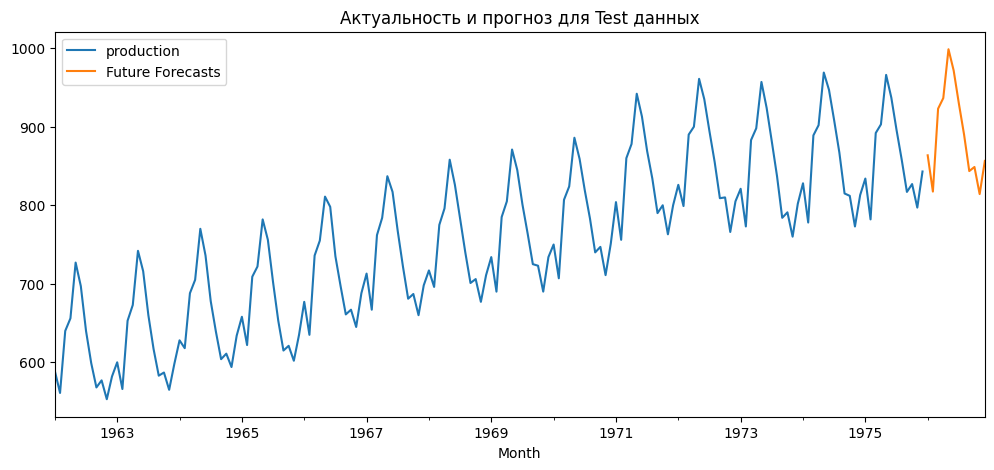

In [ ]:
milk["production"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# Данные о пассажирах

In [ ]:
air_passenger

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
print('min - ', air_passenger.min())

print('max - ', air_passenger.max())

min -  Passengers    104
dtype: int64
max -  Passengers    622
dtype: int64


In [ ]:
air_passenger.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

<Axes: xlabel='Month'>

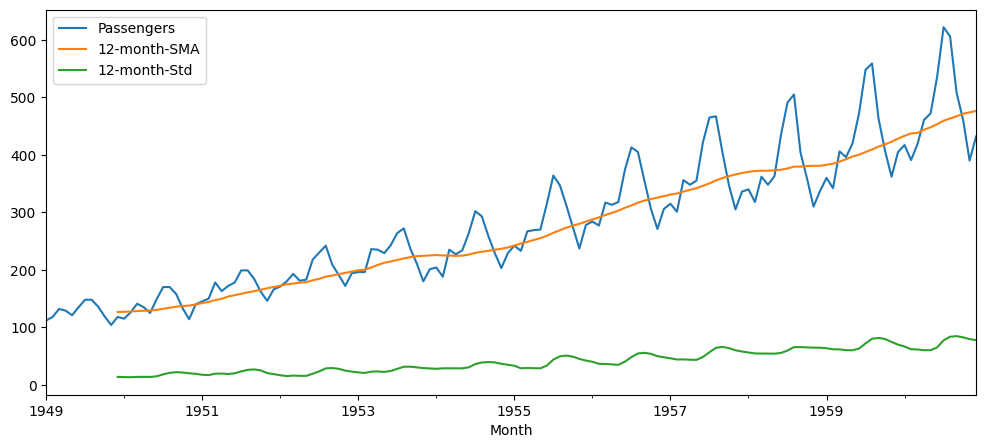

In [ ]:
# дескриптивная аналитики
air_passenger['12-month-SMA'] = air_passenger['Passengers'].rolling(window=12).mean()
air_passenger['12-month-Std'] = air_passenger['Passengers'].rolling(window=12).std()

air_passenger[['Passengers','12-month-SMA','12-month-Std']].plot(figsize=(12,5))

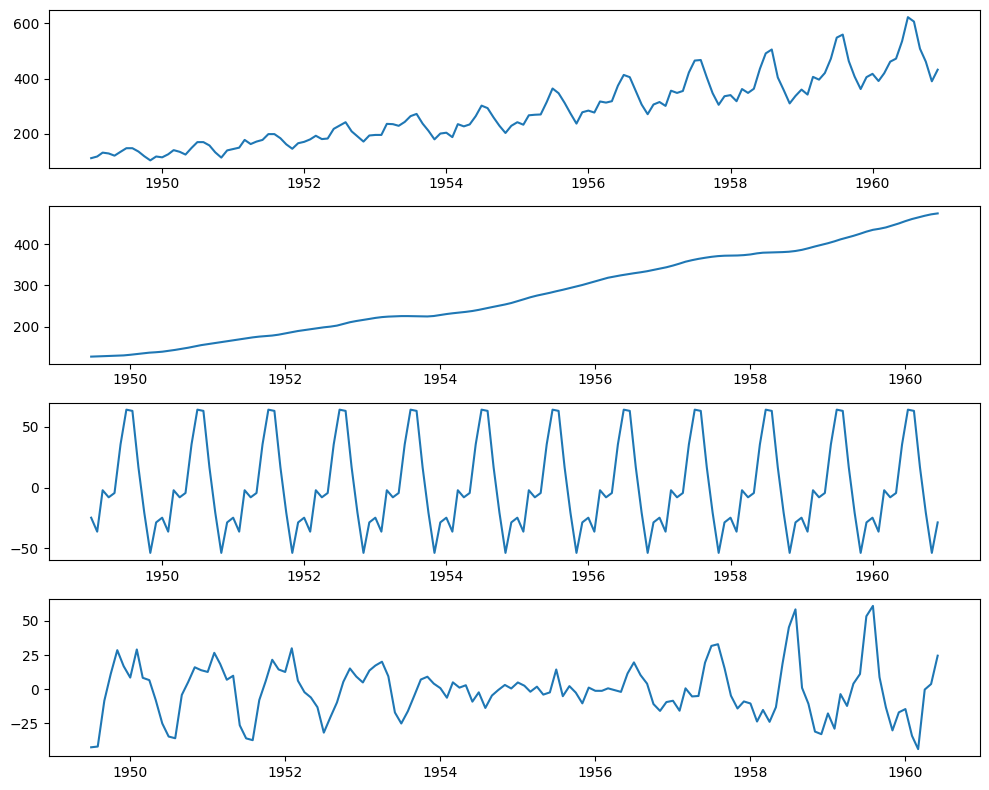

In [ ]:
decomposition = seasonal_decompose(air_passenger['Passengers'], model="add")
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[1].plot(decomposition.trend)
axes[2].plot(decomposition.seasonal)
axes[3].plot(decomposition.resid)

plt.tight_layout()
plt.show()

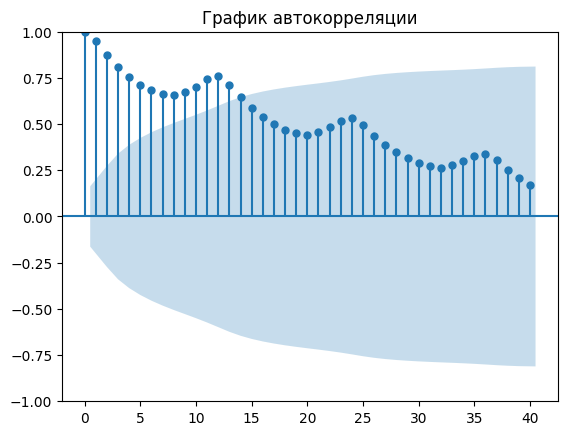

In [ ]:
# ACF
plot_acf(air_passenger['Passengers'],title='График автокорреляции', lags=40)
plt.show()

In [ ]:
# тест на стационарность

In [ ]:
adf_test(air_passenger['Passengers'])

ADF тест                        0.815369
p-value                         0.991880
# lags used                    13.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


сконвертируем нестационарный ряд в стационарный


<Axes: xlabel='Month'>

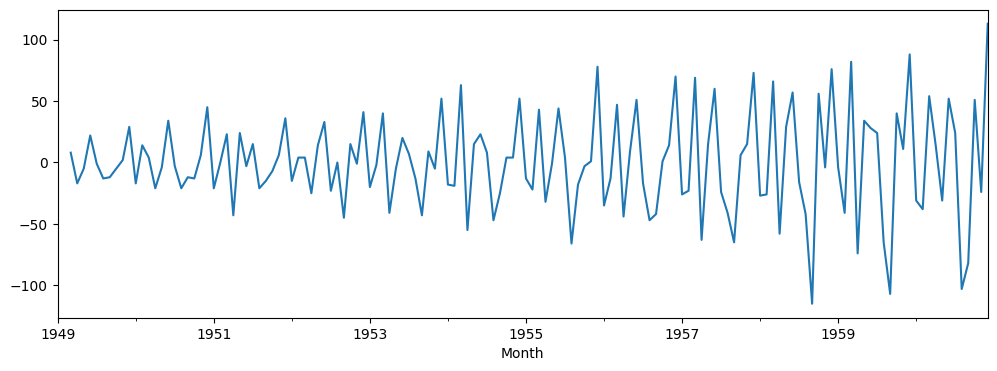

In [ ]:
air_passenger["difference_1"]= diff(air_passenger['Passengers'], k_diff=2)
air_passenger["difference_1"].plot(figsize=(12,4))

In [ ]:
adf_test(air_passenger["difference_1"])

ADF тест                     -1.638423e+01
p-value                       2.732892e-29
# lags used                   1.100000e+01
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='Month'>

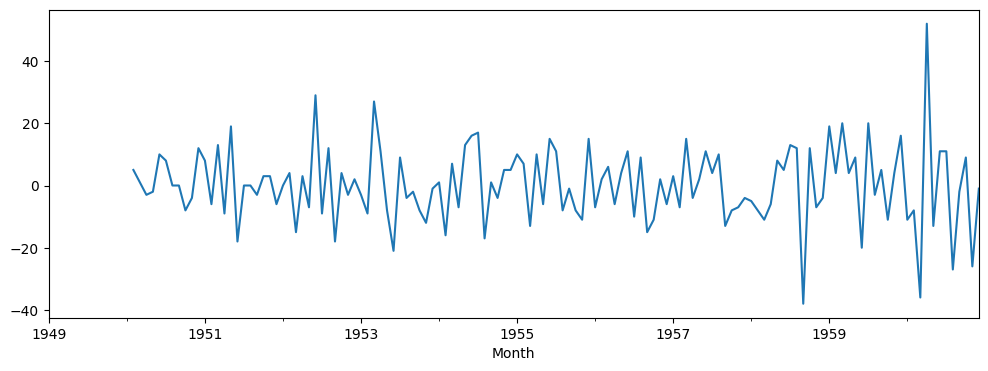

In [ ]:
# стационарность после сезонной разности
air_passenger["difference_seasonal"]= diff(air_passenger["Passengers"], k_diff=1,k_seasonal_diff= 1,seasonal_periods= 12)
air_passenger["difference_seasonal"].plot(figsize=(12,4))

In [ ]:
adf_test(air_passenger["difference_seasonal"])

ADF тест                     -1.559562e+01
p-value                       1.856512e-28
# lags used                   0.000000e+00
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### ARIMA: обучение модели без сезонной составляющей

In [ ]:
# разделим на тестовый и тренировочный набор данных
train= air_passenger.iloc[:len(air_passenger)-12]
test= air_passenger.iloc[len(air_passenger)-12:]

In [ ]:
print(len(train))
print(len(test))

132
12


In [ ]:
auto_arima_results= auto_arima(train["Passengers"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=1.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Wed, 12 Jul 2023   AIC                           1218.683
Time:                        13:20:24   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8460     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

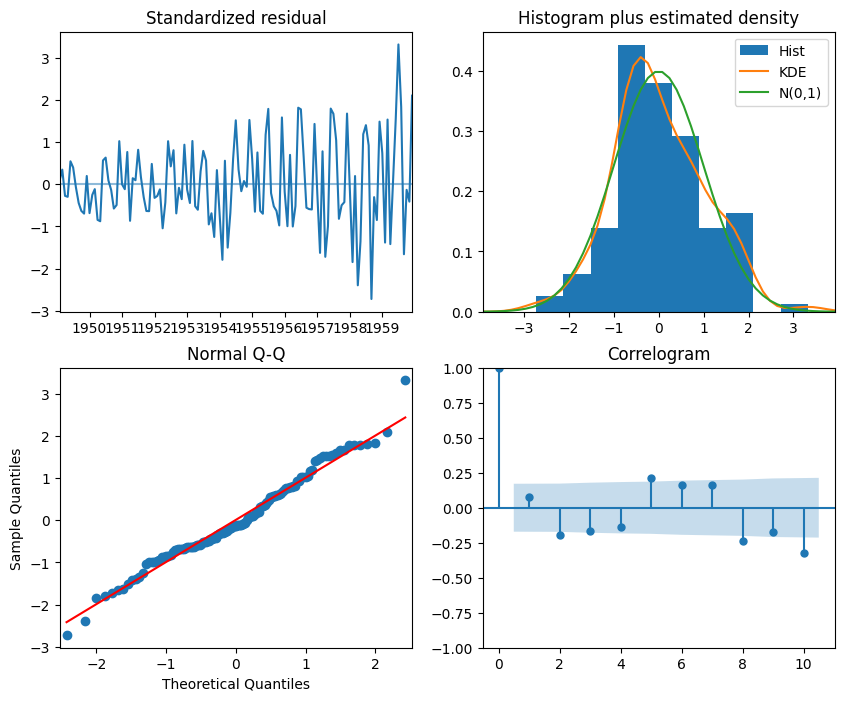

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

#### обучим модель ARIMA используя p,d,q из полученного результата по auto_arima

In [ ]:
arima_model= ARIMA(train["Passengers"], order= (2,1,2))
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
normaltest(arima_model_fit.resid)

NormaltestResult(statistic=14.0113003611032, pvalue=0.0009067441961382057)

если p-value не менее 0.05 , это означает, что остатки нормально распределены

### прогноз на test наборе данных

In [ ]:
start= len(train)
end= len(train) + len(test) -1

pred = arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='Month'>

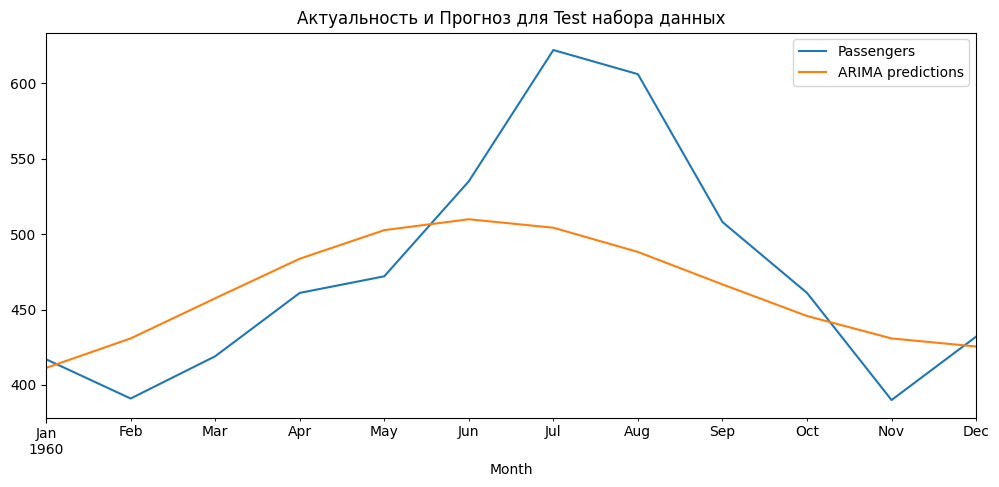

In [ ]:
title= "Актуальность и Прогноз для Test набора данных"
test["Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

In [ ]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["Passengers"],pred)
rmse_arima= rmse(test["Passengers"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 55.22283915688796 

MSE= 3049.561964547518


## ARIMA: обучение модели с сезонной составляющей

In [ ]:

smodel = auto_arima(train["Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.74 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.70 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.72 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.07 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.61 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.41 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Wed, 12 Jul 2023   AIC                            905.686
Time:                                    13:22:19   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE= 17.81560143047715 

MSE= 317.39565432961956


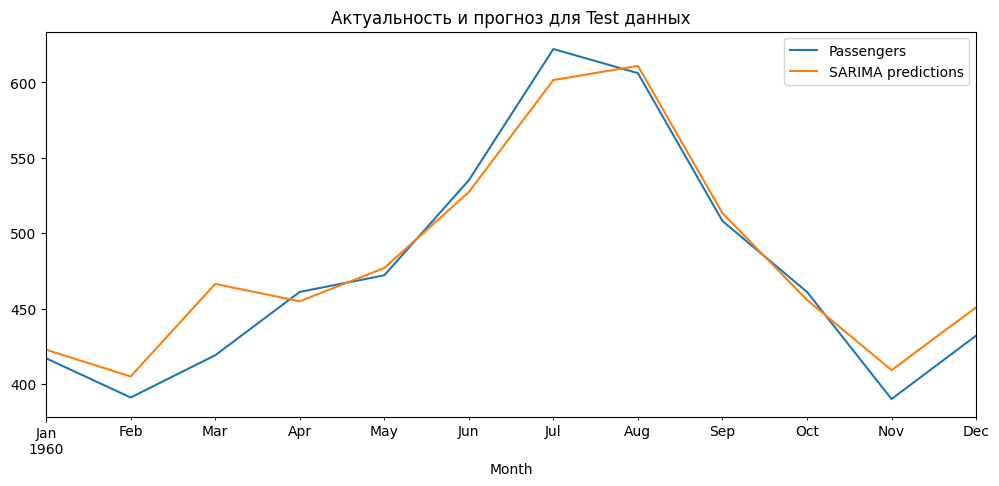

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()

# сделаем пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценим модель
mse= mean_squared_error(test["Passengers"],pred)
rmse_sarima= rmse(test["Passengers"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train['Passengers'],
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # переопределим первичный индекс


# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-73-33f806d09ab9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-73-33f806d09ab9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
# SARIMAX модель
sxmodel = auto_arima(train2["Passengers"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.32 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.77 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=1.75 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.43 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=1.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Wed, 12 Jul 2023   AIC                            905.686
Time:                                    13:23:36   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Square is 17.815600970122837 

Mean Square Error is 317.39563792664177


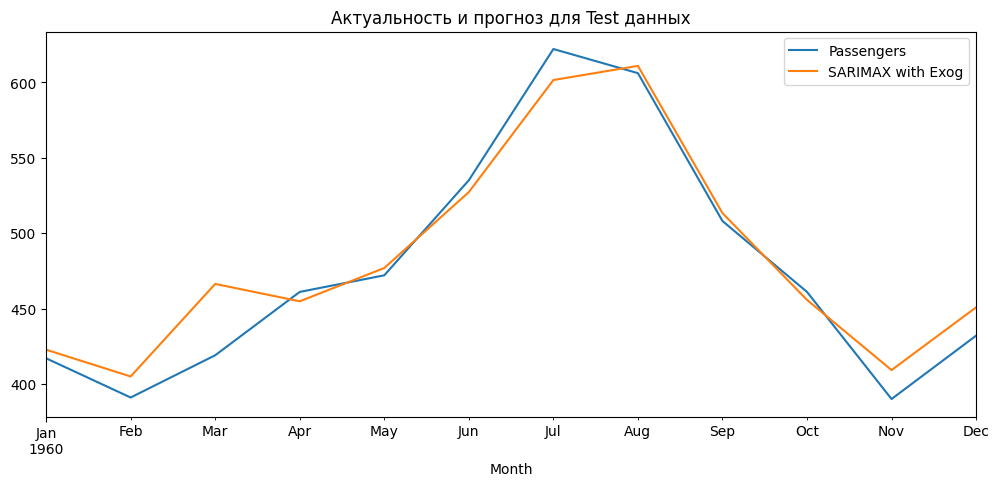

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

title= "Актуальность и прогноз для Test данных"
test["Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценка модели
mse= mean_squared_error(test["Passengers"],pred)
rmse_sarimax= rmse(test["Passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

In [ ]:
# перетренируем модель на всем объеме данных для прогноза
model= SARIMAX(air_passenger["Passengers"], order= (3,0,1), seasonal_order= (0,1,1,12))
results= model.fit()

start= len(air_passenger)
end= len(air_passenger) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## прогноз

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='Month'>

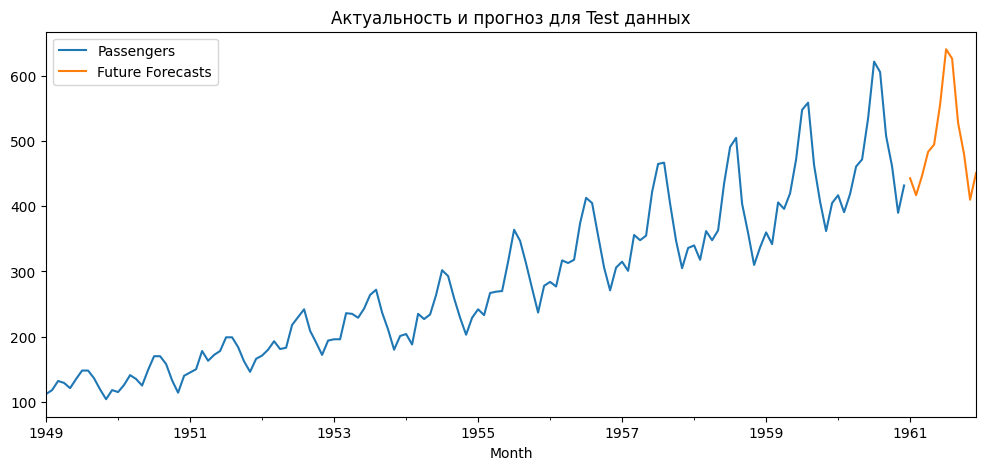

In [ ]:
air_passenger["Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# Данные о занятых

In [ ]:
aus_employment

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3
...,...
1990-11-01,7941.2
1990-12-01,7668.8
1991-01-01,7739.3


In [ ]:
print('min - ', aus_employment.min())

print('max - ', aus_employment.max())

min -  people_employed    5971.3
dtype: float64
max -  people_employed    7941.6
dtype: float64


In [ ]:
aus_employment.index

DatetimeIndex(['1978-01-01', '1978-02-01', '1978-03-01', '1978-04-01',
               '1978-05-01', '1978-06-01', '1978-07-01', '1978-08-01',
               '1978-09-01', '1978-10-01',
               ...
               '1990-06-01', '1990-07-01', '1990-08-01', '1990-09-01',
               '1990-10-01', '1990-11-01', '1990-12-01', '1991-01-01',
               '1991-02-01', '1991-03-01'],
              dtype='datetime64[ns]', name='date', length=159, freq=None)

<Axes: xlabel='date'>

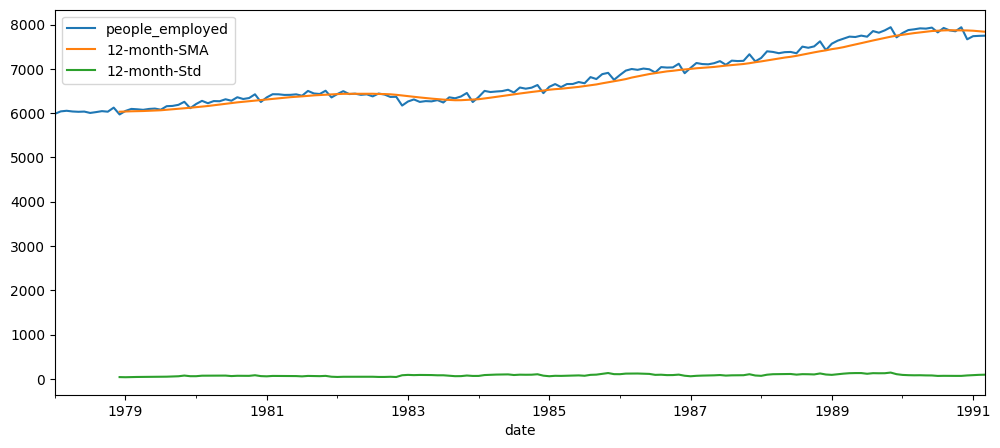

In [ ]:
# дескриптивная аналитики
aus_employment['12-month-SMA'] = aus_employment['people_employed'].rolling(window=12).mean()
aus_employment['12-month-Std'] = aus_employment['people_employed'].rolling(window=12).std()

aus_employment[['people_employed','12-month-SMA','12-month-Std']].plot(figsize=(12,5))

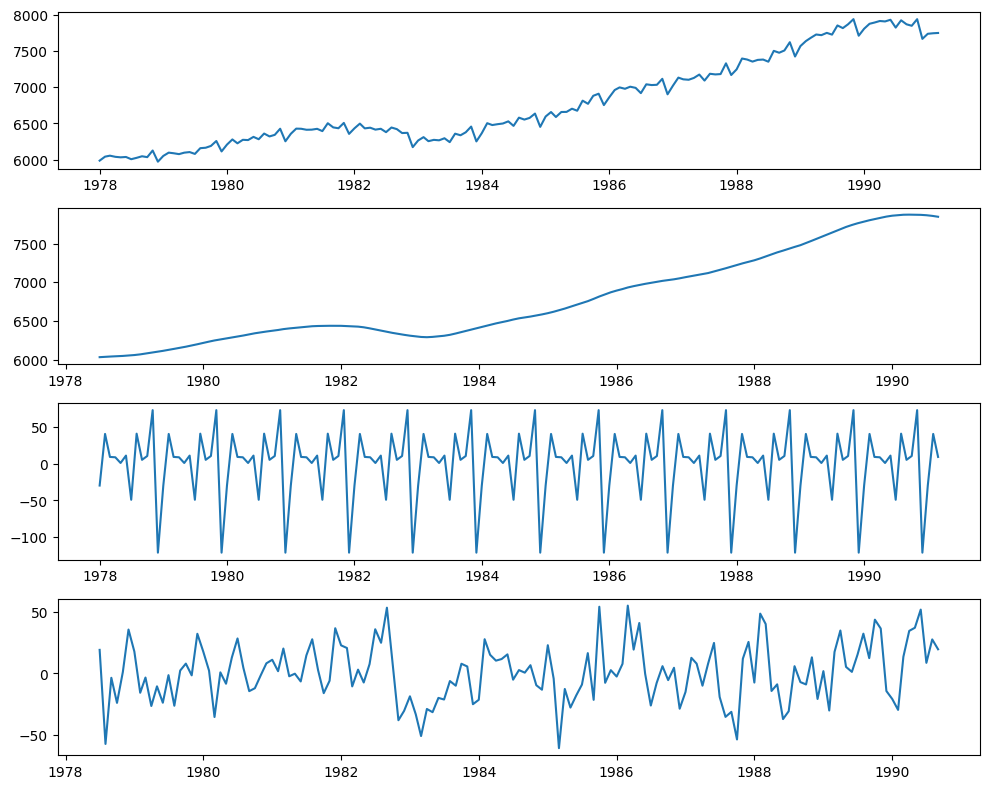

In [ ]:
decomposition = seasonal_decompose(aus_employment['people_employed'], model="add")
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[1].plot(decomposition.trend)
axes[2].plot(decomposition.seasonal)
axes[3].plot(decomposition.resid)

plt.tight_layout()
plt.show()

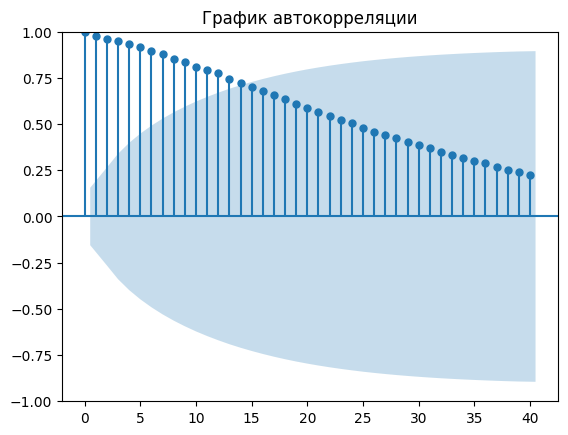

In [ ]:
# ACF
plot_acf(aus_employment['people_employed'],title='График автокорреляции', lags=40)
plt.show()

In [ ]:
# тест на стационарность

In [ ]:
adf_test(aus_employment['people_employed'])

ADF тест                       -1.400145
p-value                         0.582207
# lags used                    13.000000
# наблюдения                  145.000000
критическое значение (1%)      -3.476273
критическое значение (5%)      -2.881688
критическое значение (10%)     -2.577513
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


сконвертируем нестационарный ряд в стационарный


<Axes: xlabel='date'>

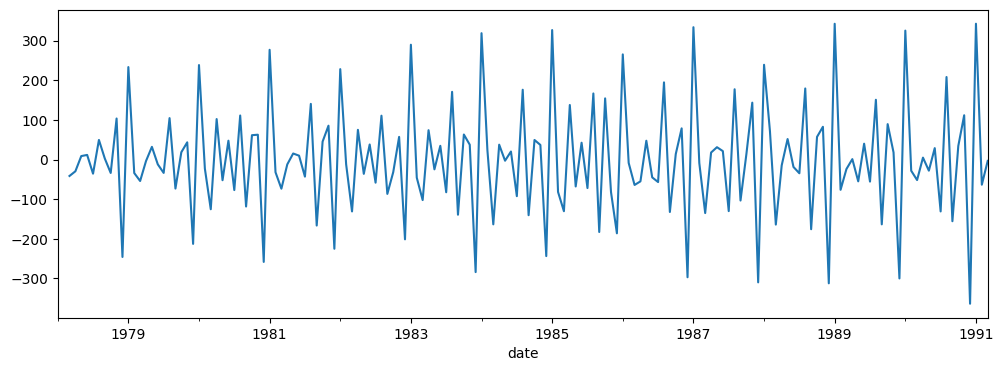

In [ ]:
aus_employment["difference_1"]= diff(aus_employment['people_employed'], k_diff=2)
aus_employment["difference_1"].plot(figsize=(12,4))

In [ ]:
adf_test(aus_employment["difference_1"])

ADF тест                     -6.080386e+00
p-value                       1.095801e-07
# lags used                   1.100000e+01
# наблюдения                  1.450000e+02
критическое значение (1%)    -3.476273e+00
критическое значение (5%)    -2.881688e+00
критическое значение (10%)   -2.577513e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='date'>

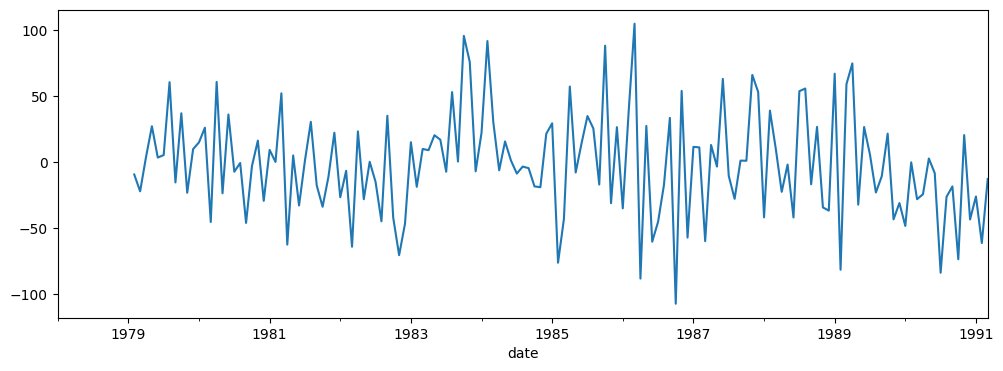

In [ ]:
# стационарность после сезонной разности
aus_employment["difference_seasonal"]= diff(aus_employment["people_employed"], k_diff=1,k_seasonal_diff= 1,seasonal_periods= 12)
aus_employment["difference_seasonal"].plot(figsize=(12,4))

In [ ]:
adf_test(aus_employment["difference_seasonal"])

ADF тест                       -4.180913
p-value                         0.000710
# lags used                    11.000000
# наблюдения                  134.000000
критическое значение (1%)      -3.480119
критическое значение (5%)      -2.883362
критическое значение (10%)     -2.578407
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


### ARIMA: обучение модели без сезонной составляющей

In [ ]:
# разделим на тестовый и тренировочный набор данных
train= aus_employment.iloc[:len(aus_employment)-12]
test= aus_employment.iloc[len(aus_employment)-12:]

In [ ]:
print(len(train))
print(len(test))

147
12


In [ ]:
auto_arima_results= auto_arima(train["people_employed"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1698.275, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1667.292, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1650.226, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1700.112, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1650.823, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1649.572, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1642.109, Time=0.97 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1631.185, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1634.148, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1632.966, Time=1.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1619.873, Time=1.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1628.063, Time=1.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1624.074, Time=1.86 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1628.083, Time=1.61 sec

Best model:  ARIMA(2,1,3)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -802.937
Date:                Wed, 12 Jul 2023   AIC                           1619.873
Time:                        13:28:22   BIC                           1640.758
Sample:                    01-01-1978   HQIC                          1628.359
                         - 03-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.9442     10.126      5.031      0.000      31.098      70.791
ar.L1         -1.6732      0.044    -38.031      0.000      -1.759      -1.587
ar.L2         -0.9089      0.042    -21.741      0.000      -0.991      -0.827
ma.L1          1.2859      0.085     15.061      0.000       1.119       1.453
ma.L2         -0.0075      0.132     -0.057      0.955      -0.266       0.251
ma.L3         -0.4894      0.074     -6.580      0.000      -0.635      -0.344
sigma2      3359.6507    369.884      9.083      0.000    2634.691    4084.610
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 8.67
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               1.82   Skew:                            -0.44
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

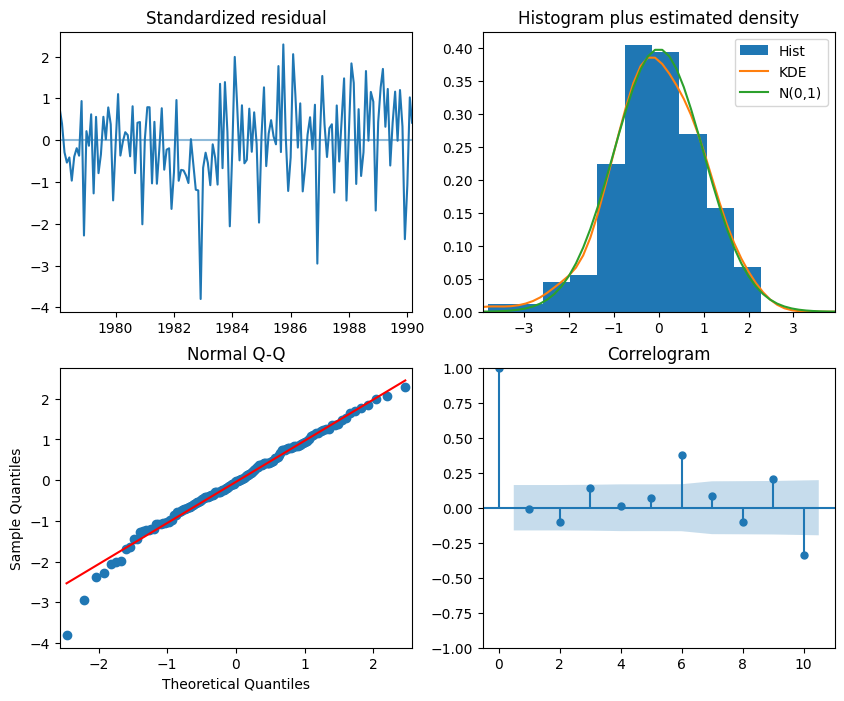

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

#### обучим модель ARIMA используя p,d,q из полученного результата по auto_arima

In [ ]:
arima_model= ARIMA(train["people_employed"], order= (2,1,3))
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
normaltest(arima_model_fit.resid)

NormaltestResult(statistic=316.41714269404844, pvalue=1.9538466481731806e-69)

если p-value не менее 0.05 , это означает, что остатки нормально распределены

### прогноз на test наборе данных

In [ ]:
start= len(train)
end= len(train) + len(test) -1

pred = arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='date'>

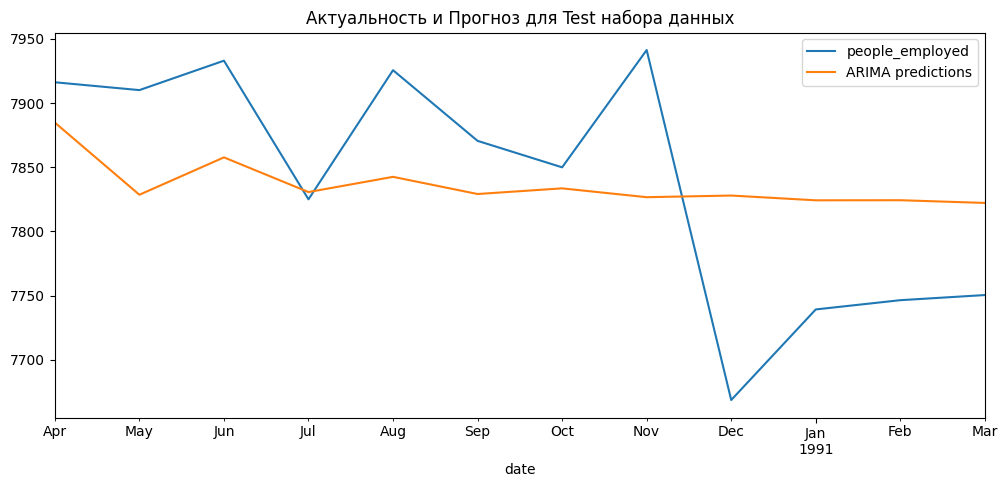

In [ ]:
title= "Актуальность и Прогноз для Test набора данных"
test["people_employed"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

In [ ]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["people_employed"],pred)
rmse_arima= rmse(test["people_employed"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 81.15611074222744 

MSE= 6586.314310804683


## ARIMA: обучение модели с сезонной составляющей

In [ ]:

smodel = auto_arima(train["people_employed"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1615.725, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1698.275, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1494.908, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1589.529, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1700.112, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1667.292, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1456.152, Time=0.99 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1593.738, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1458.067, Time=4.60 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1550.728, Time=2.26 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.57 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1459.762, Time=1.90 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  147
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -723.334
Date:                              Wed, 12 Jul 2023   AIC                           1454.669
Time:                                      13:29:46   BIC                           1466.603
Sample:                                  01-01-1978   HQIC                          1459.518
                                       - 03-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1905      0.081     -2.358      0.018      -0.349      -0.032
ar.S.L12       0.9916      0.008    130.326      0.000       0.977       1.006
ma.S.L12      -0.7088      0.094     -7.508      0.000      -0.894      -0.524
sigma2       974.4366    106.830      9.121      0.000     765.053    1183.820
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.92   Prob(JB):                         0.24
Heteroskedasticity (H):               2.02   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE= 196.41636662058906 

MSE= 38579.389076433654


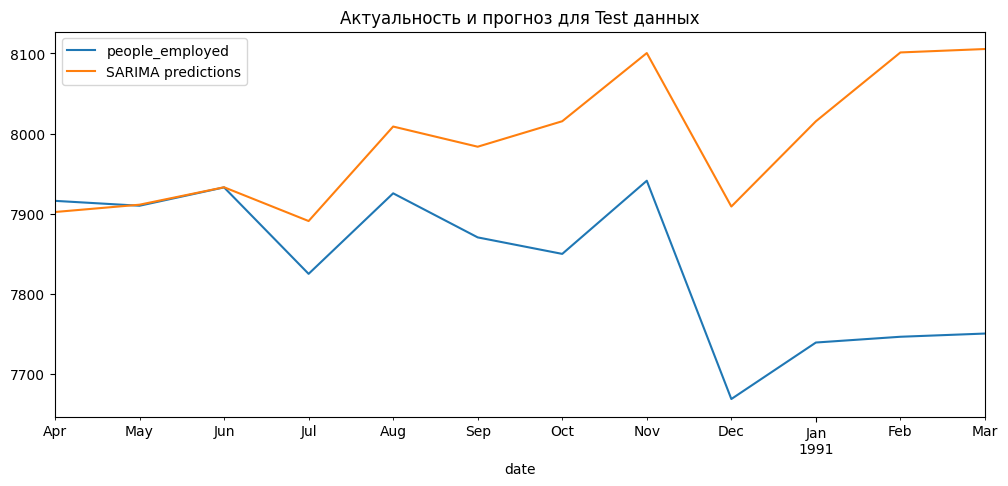

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["people_employed"], order= (1,1,0), seasonal_order= (1,0,1,12))
sarima_model_fit= sarima_model.fit()

# сделаем пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["people_employed"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценим модель
mse= mean_squared_error(test["people_employed"],pred)
rmse_sarima= rmse(test["people_employed"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train['people_employed'],
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # переопределим первичный индекс


# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-100-327f7f65e092>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-100-327f7f65e092>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
# SARIMAX модель
sxmodel = auto_arima(train2["people_employed"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1615.725, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1698.275, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1494.908, Time=0.84 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1589.529, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1700.112, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1667.292, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1456.152, Time=4.49 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1593.738, Time=1.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1458.067, Time=5.06 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1550.728, Time=2.14 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1459.762, Time=0.61 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  147
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -723.334
Date:                              Wed, 12 Jul 2023   AIC                           1454.669
Time:                                      13:31:07   BIC                           1466.603
Sample:                                  01-01-1978   HQIC                          1459.518
                                       - 03-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1905      0.081     -2.358      0.018      -0.349      -0.032
ar.S.L12       0.9916      0.008    130.326      0.000       0.977       1.006
ma.S.L12      -0.7088      0.094     -7.508      0.000      -0.894      -0.524
sigma2       974.4366    106.830      9.121      0.000     765.053    1183.820
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.92   Prob(JB):                         0.24
Heteroskedasticity (H):               2.02   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Square is 144.2021936707017 

Mean Square Error is 20794.27265944256


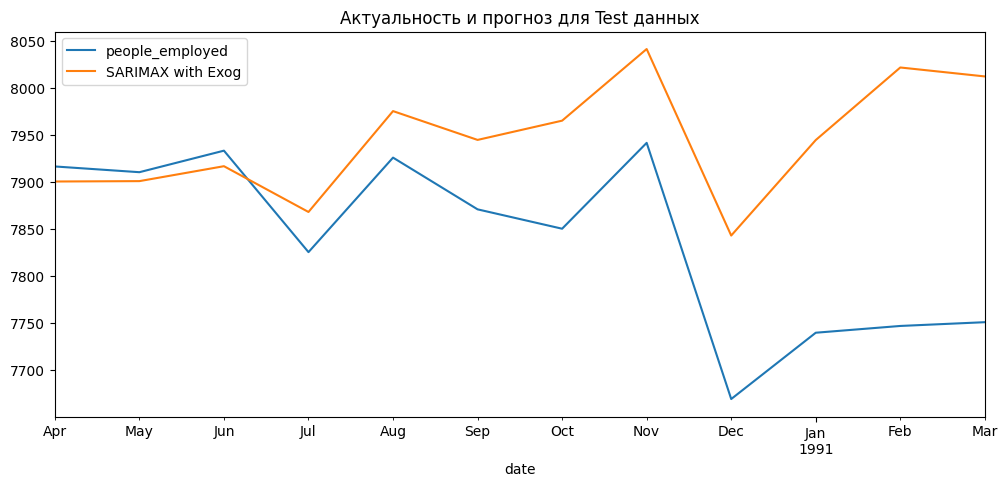

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["people_employed"], order= (1,1,0), seasonal_order= (1,0,1,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

title= "Актуальность и прогноз для Test данных"
test["people_employed"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценка модели
mse= mean_squared_error(test["people_employed"],pred)
rmse_sarimax= rmse(test["people_employed"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

In [ ]:
# перетренируем модель на всем объеме данных для прогноза
model= SARIMAX(aus_employment["people_employed"], order= (3,0,1), seasonal_order= (0,1,1,12))
results= model.fit()

start= len(aus_employment)
end= len(aus_employment) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


## прогноз

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='date'>

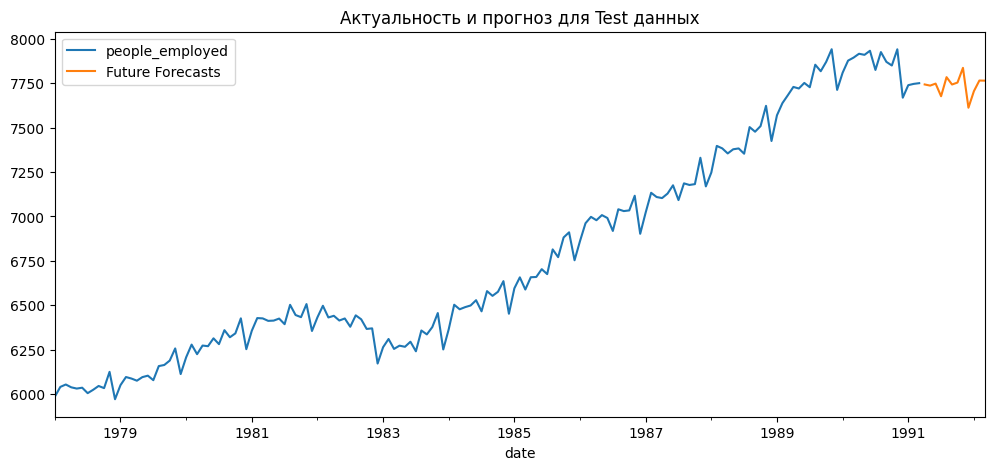

In [ ]:
aus_employment["people_employed"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)